In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import fbeta_score
from tqdm import tqdm
import cv2
from PIL import Image
from tensorflow import keras
from skimage import io
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
train_classes = pd.read_csv("C:\\Users\\kumar\\Desktop\\data_science_projects\\Hamoye stageD\\train_v2.csv\\train_v2.csv")
sample_sub = pd.read_csv("C:\\Users\\kumar\\Desktop\\data_science_projects\\Hamoye stageD\\sample_submission_v2.csv\\sample_submission_v2.csv")
train_classes.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [3]:
# dict for converting labels to numerical classes

label_map = {'agriculture': 14,
 'artisinal_mine': 5,
 'bare_ground': 1,
 'blooming': 3,
 'blow_down': 0,
 'clear': 10,
 'cloudy': 16,
 'conventional_mine': 2,
 'cultivation': 4,
 'habitation': 9,
 'haze': 6,
 'partly_cloudy': 13,
 'primary': 7,
 'road': 11,
 'selective_logging': 12,
 'slash_burn': 8,
 'water': 15}

In [4]:
# Loading the training images

x_train, y_train = [], []

for img_name, tags in tqdm(train_classes.values, miniters=1000):
    arr = cv2.imread('C:\\Users\\kumar\\Desktop\\data_science_projects\\Hamoye stageD\\train-jpg\{}.jpg'.format(img_name))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    x_train.append(cv2.resize(arr, (64, 64)))
    y_train.append(targets)

# normalizing train image pixels
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train,np.float16)/255.0

100%|██████████| 40479/40479 [04:59<00:00, 135.22it/s]


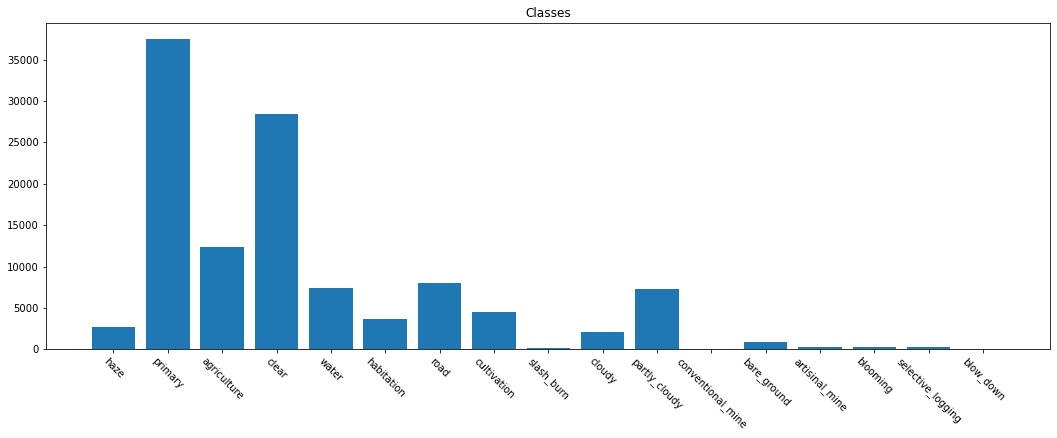

In [5]:
# numbers of tags and their names
counts = {}
splitted_tags = train_classes['tags'].map(lambda x: x.split(' '))
for labels in splitted_tags.values:
    for label in labels:
        counts[label] = counts[label] + 1  if label in counts else 0

plt.figure(figsize=(18, 6))
plt.title('Classes')
idxs = range(len(counts.values()))
plt.xticks(idxs, counts.keys(), rotation=-45)
plt.bar(idxs, counts.values());

In [6]:
len(splitted_tags)

40479

In [7]:
#load data
all_labels = splitted_tags.values
labels = list(set([y for x in all_labels for y in x]))

def load_data(train_classes, labels, resize):
    x_train = []
    y_train = []

    label_map = {l: i for i, l in enumerate(labels)}
    inv_label_map = {i: l for l, i in label_map.items()}

    for f, tags in train_classes.values:
        img = cv2.imread('C:\\Users\\kumar\\Desktop\\data_science_projects\\Hamoye stageD\\train-jpg\{}.jpg'.format(f)) 
        targets = np.zeros(17)
        for t in tags.split(' '):
            targets[label_map[t]] = 1 

        x_train.append(cv2.resize(img,resize))
        y_train.append(targets)
        
    y_train = np.array(y_train, np.uint8)
    x_train = np.array(x_train, np.float16) / 255.

    return x_train, y_train

In [8]:
import gc
gc.collect()

4055

In [9]:
x, y = load_data(train_classes, labels, resize=(64, 64))

In [10]:
gc.collect()

40

In [11]:
# checking the images of the datasets

print(train_classes.shape)
print(sample_sub.shape)

(40479, 2)
(61191, 2)


In [12]:
from sklearn.model_selection import train_test_split

import time

In [13]:
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size=0.2, random_state = int(time.time()))

In [14]:
print(y_train.shape)
print(x_train.shape)
print(x_val.shape)
print(y_val.shape)

(32383, 17)
(32383, 64, 64, 3)
(8096, 64, 64, 3)
(8096, 17)


In [15]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *


In [16]:
#pip install fastai==1.0.61

In [17]:
# Since this is a multi lable task and the labels are given as tags in a single dataframe series

biner = MultiLabelBinarizer()
tags = train_classes['tags'].str.split()
y = biner.fit_transform(tags)

labels = biner.classes_
print('Number of labels: ', len(labels))
print('\n')
print(labels)

Number of labels:  17


['agriculture' 'artisinal_mine' 'bare_ground' 'blooming' 'blow_down' 'clear' 'cloudy' 'conventional_mine' 'cultivation'
 'habitation' 'haze' 'partly_cloudy' 'primary' 'road' 'selective_logging' 'slash_burn' 'water']


In [18]:
# Getting the labels into one hot encoded form for EDA ease. 

for label in labels:
    train_classes[label] = train_classes['tags'].apply(lambda x: 1 if label in x.split()  else 0)
    
train_classes.head()

,image_name,tags,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,train_0,haze primary,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,train_1,agriculture clear primary water,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,train_2,clear primary,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,train_3,clear primary,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,train_4,agriculture clear habitation primary road,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0


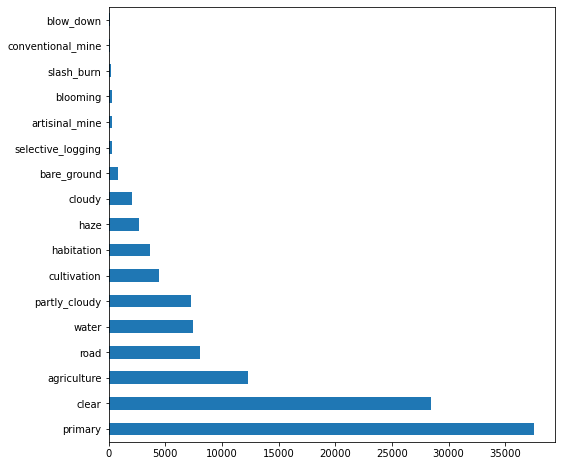

In [19]:
train_classes[labels].sum().sort_values(ascending=False).plot(kind='barh', figsize=(8,8));

In [20]:
def learning_curve(model_fit, key='acc', ylim=(0.8, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(model_fit.history[key])
    plt.plot(model_fit.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'test'], loc='best')
    plt.show()

In [21]:
def fbeta_score_K(y_true, y_pred):
    beta_squared = 4

    tp = K.sum(y_true * y_pred) + K.epsilon()
    fp = K.sum(y_pred) - tp
    fn = K.sum(y_true) - tp

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    result = (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())
    return result

In [22]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.optimizers import Adam

In [23]:
gc.collect()

4135

In [24]:
optimizer = Adam(0.003, decay=0.0005)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

for layer in base_model.layers:
    layer.trainable = False
    
    model = Sequential([
    base_model,
 
    Flatten(), 
        
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(17, activation='sigmoid')  
])

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[fbeta_score_K])
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_18 (Flatten)        (None, 2048)              0         
                                                                 
 dense_36 (Dense)            (None, 128)               262272    
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                                                 
 dense_37 (Dense)            (None, 17)                2193      
                                                                 
Total params: 14,979,153
Trainable params: 264,465
Non-trainable params: 14,714,688
_________________________________________________________________


In [25]:
model_fit = model.fit( x_train, y_train, batch_size=64, epochs=10, verbose=1, validation_data=(x_val, y_val))

Epoch 1/10
506/506 [==============================] - 716s 1s/step - loss: 0.1739 - fbeta_score_K: 0.7020 - val_loss: 0.1499 - val_fbeta_score_K: 0.7379
Epoch 2/10
506/506 [==============================] - 721s 1s/step - loss: 0.1483 - fbeta_score_K: 0.7408 - val_loss: 0.1415 - val_fbeta_score_K: 0.7436
Epoch 3/10
506/506 [==============================] - 719s 1s/step - loss: 0.1419 - fbeta_score_K: 0.7515 - val_loss: 0.1391 - val_fbeta_score_K: 0.7548
Epoch 4/10
506/506 [==============================] - 720s 1s/step - loss: 0.1385 - fbeta_score_K: 0.7576 - val_loss: 0.1356 - val_fbeta_score_K: 0.7543
Epoch 5/10
506/506 [==============================] - 721s 1s/step - loss: 0.1354 - fbeta_score_K: 0.7628 - val_loss: 0.1336 - val_fbeta_score_K: 0.7646
Epoch 6/10
506/506 [==============================] - 720s 1s/step - loss: 0.1333 - fbeta_score_K: 0.7666 - val_loss: 0.1331 - val_fbeta_score_K: 0.7618
Epoch 7/10
506/506 [==============================] - 723s 1s/step - loss: 0.1322 

In [26]:
y_pred = model.predict(x_val, batch_size=64)
score = fbeta_score(y_val, np.array(y_pred) > 0.2, beta=2, average='samples')

print("Test score (f1): ", score)
print("Error: %.2f%%" % (100-score*100))

Test score (f1):  0.8803022628843048
Error: 11.97%


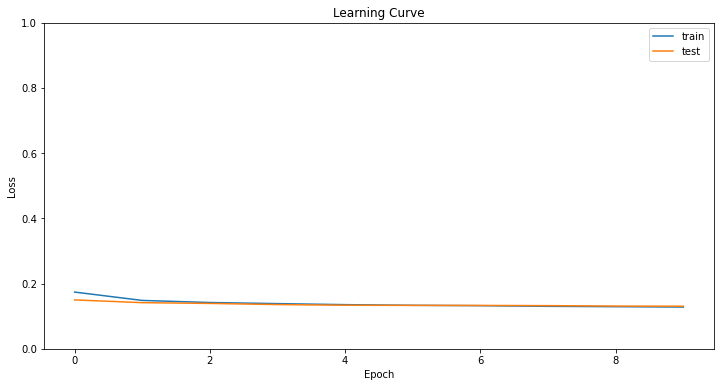

In [27]:
learning_curve(model_fit, key='loss', ylim=(0, 1))

In [28]:
gc.collect()

6505

In [29]:
# decrease learning step and decay

optimizer = Adam(0.0001, decay=0.00001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[fbeta_score_K])

model_fit = model.fit(
    x_train, y_train,
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_data=(x_val, y_val))

Epoch 1/10
506/506 [==============================] - 628s 1s/step - loss: 0.1244 - fbeta_score_K: 0.7799 - val_loss: 0.1295 - val_fbeta_score_K: 0.7754
Epoch 2/10
506/506 [==============================] - 594s 1s/step - loss: 0.1241 - fbeta_score_K: 0.7802 - val_loss: 0.1293 - val_fbeta_score_K: 0.7757
Epoch 3/10
506/506 [==============================] - 590s 1s/step - loss: 0.1239 - fbeta_score_K: 0.7807 - val_loss: 0.1291 - val_fbeta_score_K: 0.7763
Epoch 4/10
506/506 [==============================] - 606s 1s/step - loss: 0.1238 - fbeta_score_K: 0.7806 - val_loss: 0.1291 - val_fbeta_score_K: 0.7776
Epoch 5/10
506/506 [==============================] - 624s 1s/step - loss: 0.1234 - fbeta_score_K: 0.7811 - val_loss: 0.1289 - val_fbeta_score_K: 0.7756
Epoch 6/10
506/506 [==============================] - 608s 1s/step - loss: 0.1234 - fbeta_score_K: 0.7813 - val_loss: 0.1290 - val_fbeta_score_K: 0.7756
Epoch 7/10
506/506 [==============================] - 592s 1s/step - loss: 0.1233 

In [30]:
y_pred = model.predict(x_val, batch_size=64)
score = fbeta_score(y_val, np.array(y_pred) > 0.2, beta=2, average='samples')

print("Test score (f1): ", score)
print("Error: %.2f%%" % (100-score*100))

Test score (f1):  0.8827521116813606
Error: 11.72%


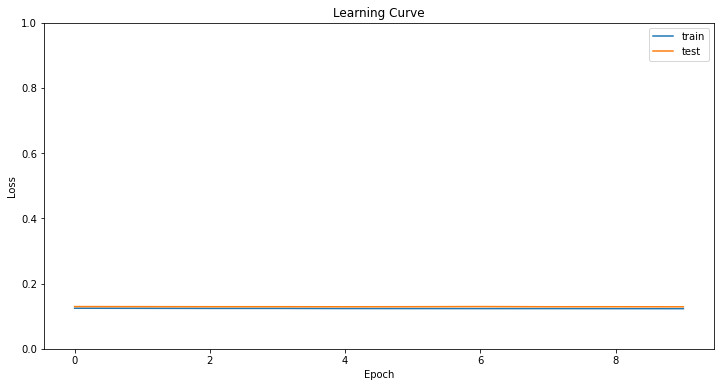

In [31]:
learning_curve(model_fit, key='loss', ylim=(0, 1))

In [32]:
gc.collect()

4390

In [33]:
# adding more layer to learn

for layer in model.layers[0].layers[1:]:
    layer.trainable = True

for layer in model.layers[0].layers:
    print(layer.name, layer. trainable)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[fbeta_score_K])
model.summary()

input_1 False
block1_conv1 True
block1_conv2 True
block1_pool True
block2_conv1 True
block2_conv2 True
block2_pool True
block3_conv1 True
block3_conv2 True
block3_conv3 True
block3_pool True
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_18 (Flatten)        (None, 2048)              0         
                                                                 
 dense_36 (Dense)            (None, 128)               262272    
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                                  

In [35]:
model_fit = model.fit(
    x, y,
    batch_size=64,
    epochs=1,
    verbose=1,
    validation_data=(x_val, y_val))

633/633 [==============================] - 2850s 5s/step - loss: 0.2093 - fbeta_score_K: 0.6452 - val_loss: 0.8441 - val_fbeta_score_K: 0.3192


In [36]:
y_pred = model.predict(x_val, batch_size=64)
score = fbeta_score(y_val, np.array(y_pred) > 0.2, beta=2, average='samples')

print("F beta score: ", score)
print("Error: %.2f%%" % (100-score*100))

F beta score:  0.4160967162207852
Error: 58.39%


In [37]:
gc.collect()

956

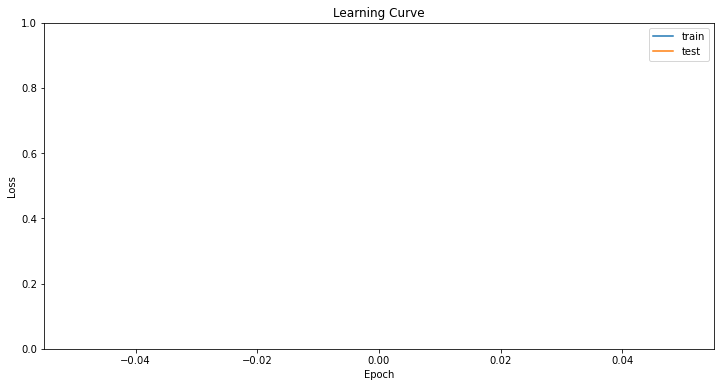

In [38]:
learning_curve(model_fit, key='loss', ylim=(0, 1))

In [39]:
# I will check fit_generator for my the best solution

aug = keras.preprocessing.image.ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                         width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                         horizontal_flip=True, fill_mode="nearest")
 
model_fit = model.fit_generator(aug.flow(x, y, batch_size=64),
                        validation_data=(x_val, y_val), steps_per_epoch=len(x) // 128,
                        epochs=5)

<ipython-input-39-a7d007e1b686>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_fit = model.fit_generator(aug.flow(x, y, batch_size=64),


Epoch 1/5
316/316 [==============================] - 1818s 6s/step - loss: 0.2028 - fbeta_score_K: 0.6547 - val_loss: 0.9889 - val_fbeta_score_K: 0.3172
Epoch 2/5
316/316 [==============================] - 1928s 6s/step - loss: 0.1981 - fbeta_score_K: 0.6619 - val_loss: 0.9289 - val_fbeta_score_K: 0.3231
Epoch 3/5
316/316 [==============================] - 1920s 6s/step - loss: 0.1941 - fbeta_score_K: 0.6671 - val_loss: 1.0593 - val_fbeta_score_K: 0.3173
Epoch 4/5
316/316 [==============================] - 1739s 6s/step - loss: 0.1882 - fbeta_score_K: 0.6730 - val_loss: 0.9185 - val_fbeta_score_K: 0.3132
Epoch 5/5
316/316 [==============================] - 1521s 5s/step - loss: 0.1837 - fbeta_score_K: 0.6795 - val_loss: 1.2541 - val_fbeta_score_K: 0.3178


In [40]:
y_pred = model.predict(x_val, batch_size=64)
score = fbeta_score(y_val, np.array(y_pred) > 0.2, beta=2, average='samples')

print("F beta score: ", score)
print("Error: %.2f%%" % (100-score*100))

F beta score:  0.35848353903339525
Error: 64.15%


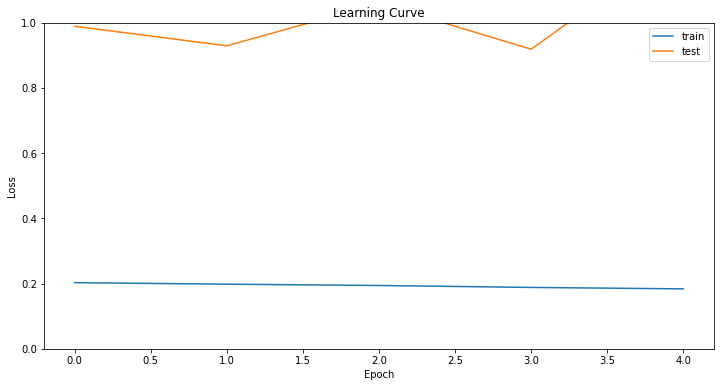

In [41]:
learning_curve(model_fit, key='loss', ylim=(0, 1))

In [50]:
# now to check the Test data


X_test=[]

for img, label in tqdm(sample_sub[:40669].values, miniters = 1000):
    X_test.append(cv2.resize(cv2.imread("C:\\Users\\kumar\\Desktop\\data_science_projects\\Hamoye stageD\\test-jpg\\test-jpg\{}.jpg".format(img)), (64,64)))


x_test = np.array(X_test, np.float16)/255

100%|██████████| 40669/40669 [01:33<00:00, 433.06it/s]


In [51]:
x_test.shape

(40669, 64, 64, 3)

In [52]:
Test_Predictions = model.predict(x_test, batch_size = 64)

In [53]:
Test_Predictions

array([[1.830280e-03, 5.240171e-09, 2.991124e-05, 4.489318e-05, ..., 5.516410e-04, 1.159061e-06, 4.964581e-08,
        2.808654e-02],
       [1.072111e-01, 1.855493e-04, 4.359275e-03, 6.842107e-03, ..., 4.387110e-02, 2.110153e-03, 5.724430e-04,
        2.097216e-01],
       [3.443578e-01, 9.500419e-06, 1.133445e-02, 6.659925e-04, ..., 1.213678e-01, 1.883298e-03, 2.925694e-04,
        4.187858e-02],
       [3.571457e-02, 9.152405e-06, 1.467615e-03, 1.714587e-03, ..., 1.173714e-02, 2.325773e-04, 4.816055e-05,
        1.325307e-01],
       ...,
       [5.904270e-01, 3.424019e-03, 4.737616e-03, 8.065283e-03, ..., 3.104519e-01, 5.266368e-03, 3.258437e-03,
        3.530166e-01],
       [6.483449e-01, 9.563476e-03, 1.537007e-02, 1.572818e-02, ..., 4.406978e-01, 1.287380e-02, 4.307121e-03,
        3.292917e-01],
       [3.333538e-01, 4.602808e-06, 1.167402e-02, 5.650222e-04, ..., 1.033564e-01, 1.793057e-03, 2.789795e-04,
        4.118627e-02],
       [5.833209e-04, 1.477663e-10, 4.711951e-06, 

In [54]:
pred = pd.DataFrame(Test_Predictions, columns= labels)
pred


,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,0.001830,5.240171e-09,0.000030,0.000045,3.812660e-08,0.999303,1.548846e-06,1.841579e-09,0.001616,0.000235,0.000933,0.000283,1.000000,0.000552,1.159061e-06,4.964581e-08,0.028087
1,0.107211,1.855493e-04,0.004359,0.006842,3.027618e-04,0.990272,2.769232e-04,4.087625e-05,0.083949,0.017362,0.016297,0.009788,0.999904,0.043871,2.110153e-03,5.724430e-04,0.209722
2,0.344358,9.500419e-06,0.011334,0.000666,2.900108e-05,0.077137,3.747156e-02,2.639890e-04,0.089598,0.005886,0.052854,0.883594,0.941486,0.121368,1.883298e-03,2.925694e-04,0.041879
3,0.035715,9.152405e-06,0.001468,0.001715,1.980760e-05,0.992886,1.002372e-04,2.759703e-06,0.033278,0.003932,0.008556,0.006443,0.999986,0.011737,2.325773e-04,4.816055e-05,0.132531
4,0.186641,1.245439e-04,0.010819,0.000607,1.231328e-04,0.072296,1.035281e-01,5.736053e-04,0.035074,0.006094,0.060675,0.526892,0.654427,0.070355,1.497090e-03,1.185220e-04,0.042858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40664,0.001526,2.930814e-09,0.000022,0.000034,2.254063e-08,0.999472,9.658338e-07,9.666183e-10,0.001385,0.000181,0.000740,0.000214,1.000000,0.000441,7.614776e-07,3.061065e-08,0.026311
40665,0.590427,3.424019e-03,0.004738,0.008065,1.225650e-03,0.977900,1.603365e-04,1.211865e-04,0.279250,0.045770,0.016502,0.013984,0.999889,0.310452,5.266368e-03,3.258437e-03,0.353017
40666,0.648345,9.563476e-03,0.015370,0.015728,2.837986e-03,0.981429,1.890957e-04,9.108782e-04,0.295752,0.178794,0.021327,0.026578,0.998349,0.440698,1.287380e-02,4.307121e-03,0.329292
40667,0.333354,4.602808e-06,0.011674,0.000565,1.772324e-05,0.081033,3.166384e-02,2.047420e-04,0.102391,0.004092,0.045330,0.908729,0.960855,0.103356,1.793057e-03,2.789795e-04,0.041186


In [55]:
labels

array(['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine',
       'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn',
       'water'], dtype=object)

In [56]:
# kaggle submission

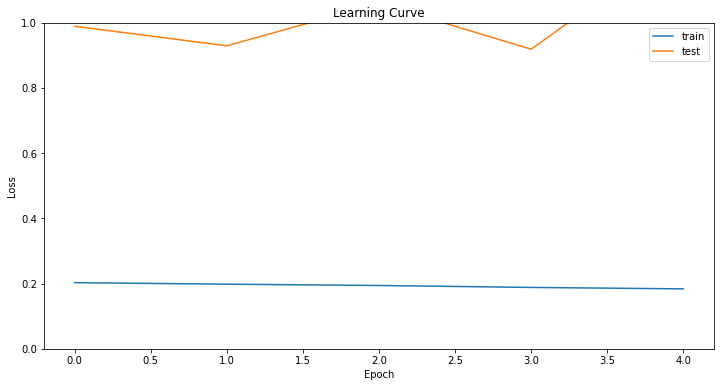

In [57]:
learning_curve(model_fit, key='loss', ylim=(0, 1))

In [58]:
final_pred = []

for i in tqdm(range(pred.shape[0]), miniters=1000):
    a = pred.loc[[i]]
    a = a.apply(lambda x:x>0.2, axis =1)
    a = a.transpose()
    a = a.loc[a[i]==True]
    ' '.join(list(a.index))
    final_pred.append(' '.join(list(a.index)))

100%|██████████| 40669/40669 [02:01<00:00, 335.93it/s]


In [59]:
gc.collect()

9865

In [62]:
sample_sub.to_csv('Final.csv', index = False)